(sec:StochasticProcesses)=
# Stochastic processes

```{epigraph}
> "Stochastic, or random, processes is the dynamic side of probability. What differential equations is to calculus, stochastic processes is to probability."

-- Robert P. Dobrow, *Introduction to Stochastic Processes with R*
```

## Notation

{{ sub_StochasticProcesses_notation }}

## Introduction

A stochastic (random) process is simply one in which outcomes are uncertain. By contrast, a deterministic process always produces the same result for a given input. While functions and differential equations are often used to describe deterministic processes, we can use random variables and probability distribution functions to describe stochastic ones. 

Stochastic processes are very useful for the modeling of systems that have inherent randomness. This is certainly true in physics, and not the least for quantum systems. We will not delve deep into this topic in these notes. You might encounter stochastic modeling in the future when studying, for example, statistical physics. 

Instead, our specific goal is to become familiar with a special kind of stochastic processes known as Markov chains. Having defined and studied general properties, we will find that such chains be designed to produce samples from a stationary probability distribution of our choice. 

```{admonition} Discuss
Why is it so useful in Bayesian inference to be able to produce samples from a user-specified probability distrbution?
```


```{prf:example} An exponential growth model
:label: example:exponential-growth-models

Consider a simple exponential growth model to describe a population of bacteria in a culture with a food source. In a deterministic model we assert that the population grows at a fixed rate $\lambda$. The growth rate is then proportional to the population size as described by the differential equation

\begin{equation}
\frac{dy}{dt} = \lambda y(t).
\end{equation}

With the initial population $y(0) = y_0$, this equation is solved by the exponential function 

\begin{equation}
y(t) = y_0 \exp(\lambda t),
\end{equation} 

from which the population is precisely determined. For example, with $y_0 = 10$ and $\lambda = 0.25$ per minute we find that the population has almost doubled four times
after 11 minutes (since $y(11) = 15.6 \approx 16$). 

This model, however, does not take into account the randomness of the reproduction of individual organisms. This can be considered in a stochastic growth model where we assign the probability $\lambda \Delta t$ for a single bacteria to split once during a (very short) time interval $\Delta t$. This random process can be simulated using a short python script (click below to show the code). Ten different realizations of the stochastic model are visualized in {numref}`fig-bacterial-growth` and compared with the deterministic one. Questions that might be of scientific interest include:

* What is the expected number of bacteria at time $t$?
* What is the probability that the number of bacteria will exceed some threshold value after $t$ minutes?
* What is the distribution of the time it takes for the population to double in size? 
```

65.0

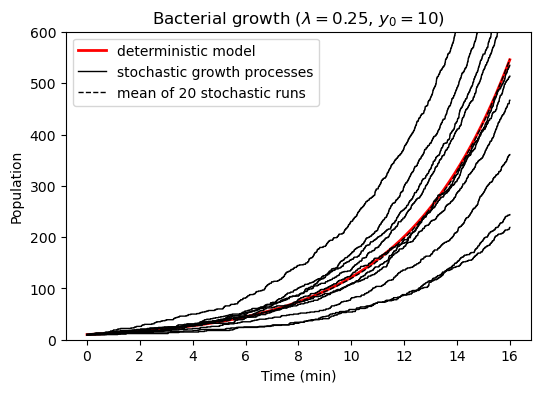

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from myst_nb import glue

# Set the relevant time interval and the model parameters
t = np.linspace(0,16,num=20000)
lam=0.25
y0=10

# Deterministic model
def y_deterministic(t,y0=1,lam=0.2):
    return y0*np.exp(lam*t)
    
# Stochastic model
def y_stochastic(t,y0=1,lam=0.2):
    y = [y0]
    assert max(t[1:]-t[:-1])/lam < 0.01, "The time interval must be much smaller than lambda."
    t_old = t[0]
    for t_i in t[1:]:
        dt = t_i-t_old
        t_old=t_i
        y_i = y[-1]
        # Increase the number of bacteria by the number of splits
        y_i += np.sum(np.random.random(y_i)<lam*dt)
        y.append(y_i)
    return np.array(y)
    
# Create a visualization
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, **{"figsize":(6,4)})
ax.plot(t,y_deterministic(t,lam=lam,y0=y0),label='deterministic model',lw=2,color='red')
y_max = 1.1 * y_deterministic(t[-1],lam=lam,y0=y0)
np.random.seed(seed=3)
num_runs=20
y_runs = np.zeros((num_runs,len(t)))
for irun in range(num_runs):
    y_run = y_stochastic(t,lam=lam,y0=y0)
    if irun==0: label='stochastic growth processes'
    else: label=''
    if irun%2==0: ax.plot(t,y_run,lw=1,color='k',label=label)
    y_runs[irun,:] = y_run
y_mean = y_runs.mean(axis=0)
ax.plot(t,y_mean,lw=1,ls='--',color='k',label=f'mean of {num_runs} stochastic runs')
ax.set_ylim((0,y_max))
ax.legend(loc='best')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Population')
ax.set_title(rf'Bacterial growth ($\lambda={lam}$, $y_0={y0}$)')

glue("bacterial-growth_fig", fig, display=False)

# How large is the probability that the number of bacteria exceeds 100 after 10 mins?
i10 = np.argmin(np.abs(t-10))
fraction_100_after_10min = 100 * np.sum(y_runs[:,i10]>100) / num_runs
glue("growth_question", fraction_100_after_10min)

```{glue:figure} bacterial-growth_fig
:name: "fig-bacterial-growth"

Growth of a bacteria population. The deterministic exponential growth curve is plotted against a number of realizations of a stochastic growth process. We find for example that {glue:text}`growth_question:.0f`% of the processes give 100 bacteria after ten minutes.
```

## Definition of a stochastic process

Using probability theory, a stochastic process $X$ is a family 

\begin{equation}
\{X_t \; : \; t \in T\},
\end{equation}

of random variables $X_t$ indexed by some set $T$. All the random variables take values in a common state space, $S$. The state space can be discrete or continuous. Although we might use discrete state spaces in some of the examples, one should realize that most examples in physics belong to the continuous type.

Furthermore, the family is known as **discrete process** if the indices take discrete values $t \in \{0,1,2,\ldots\}$. This will in fact be the situation in the practical application of **Markov chain Monte Carlo** applications that we are aiming for. On the other hand, many physical stochastic processes are **continuous** and will have $T \in \mathbb{R}$ or $t \in [0,\infty)$. In either case we think of a stochastic process as a family of variables that evolve as time passes, although in general $T$ might be any kind of ordering index and is not restricted to physical time.

Due to the randomness, different runs of the stochastic process will generate different sequences of outputs. An observer recording many such sequences generated from the same stochastic process would need to measure all the following conditional probabilities to fully describe the process:

\begin{equation}
\begin{gathered}
p_{X_0}(x_0), \\
p_{X_1 \vert X_0}(x_1 | x_0), \\
p_{X_2 \vert X_0, X_1}(x_2 | x_0, x_1), \\
\vdots\\
p_{X_n \vert X_0, X_1, \ldots, X_{n-1}} \left( x_n | x_0, x_1, \ldots, x_{n-1} \right).
\end{gathered}
\end{equation}

```{prf:example} Conditional probabilities of a stochastic process
:label: example:conditional-stochastic-process

Below is an example of a stochastic process (implemented using an abstract python class [`StochasticProcess`](https://gitlab.com/cforssen/tif385-book/-/blob/tif385/content/Utils/StochasticProcess/StochasticProcess.py)).

Note that the process indeed is defined by: 
1. the distribution of the first random variable $X_0$, which is included in the definition of class method `start`, and 
2. the conditional distributions for subsequent variables (as defined in the class method `update`). 

Two relevant visualizations are also included in the example below
* Plots of the first variables from a few runs.
* A corner plot of bivariate and univariate marginal distributions.
```

In [2]:
import sys
import os
# Adding ./CodeLocal/ to the python module search path
# sys.path.insert(0, os.path.abspath('../../Utils/'))
sys.path.append('./CodeLocal')

from StochasticProcess.StochasticProcess import StochasticProcess as SP

class StochasticProcessExample(SP):
    def start(self,random_state):
        return random_state.uniform()

    def update(self, random_state, history):
        return np.sum(history) + random_state.uniform()

In [3]:
# Create an instance of the class. It is possible to provide a seed
# for the random state such that results are reproducible.
example = StochasticProcessExample(seed=1)

# The following method call produces 4 runs, each of length 10.
example.create_multiple_processes(10,4)

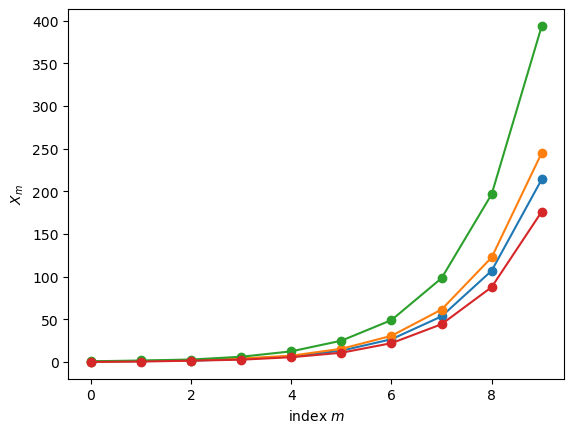

In [4]:
# and here plotted
fig_runs, ax_runs = example.plot_processes()

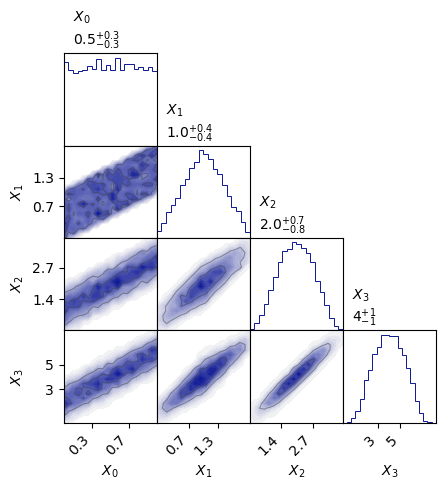

In [5]:
# Pretty corner plots generated with `prettyplease`
# https://github.com/svisak/prettyplease 
import prettyplease.prettyplease as pp

# Here we instead create 10,000 runs (to collect statistics), each of length 4.
example.create_multiple_processes(4,10000)
fig_corner = pp.corner(example.sequence.T,labels=[fr'$X_{{{i}}}$' for i in range(13)])

```{exercise}
:label: exercise:StochasticProcess:first-example

Can you understand the initialization and update rules of {prf:ref}`example:conditional-stochastic-process`?
```

```{exercise}
:label: exercise:conditional-probabilities-stochastic-process

For each panel of the pairplot above:

* What conditional distribution of random variables does each panel show?
* What random variables are marginalized out, if any?
* Explain how the pairplot answers the question "Are $X_3$ and $X_0$ independent?"?

Hints: 
* The top-left panel shows $\p{X_0}$, with no marginalization since $X_0$ starts the random sequence. 
* The independence of $X_3$ and $X_0$ would imply $\pdf{X_3}{X_0}=\p{X_3}$.
```

```{exercise}
:label: exercise:construct-stochastic-process

Define your own stochastic process by creating your own initial and update methods within the StochasticProcess class. Explore the conditional probabilities by creating many chains and making plots. 
```


## Example: Random walk

One of the simplest random processes is the so called *random walk*. This process can arise in many ways. A standard example is the coin-flip casino game in which a gambler G starts with a fortune $a$. The croupier tosses a (possibly biased) coin. Each time heads appears, the gambler gets one euro (let us assume that the game takes place in Monte Carlo). If tails appears, the player loses one euro. 

The player's fortune $S_n$  after $n$ tosses is

\begin{equation}
S_n = a + \sum_{i=1}^n X_i,
\end{equation}

where $X_i$ is a random variable with possible outcomes $\{-1,1\}$. The probability mass function is $\{ p(X_i = -1) = p, p(X_i = 1) = 1-p \}$, where an unbiased coin would have $p=0.5$. The fortune $S_n$ can be considered a random walk stochastic process. A number of different scenarios can be considered by imposing external constraints on the gambler's fortune (such as the termination of the game when $S_n = 0$).

```{prf:example} Simple random walk
:label: example:simple-random-walk
In the following code example (again using the `StochasticProcess` class) we create a large number of such processes starting at $X_0 = 0$. Here we investigate the questions:

* What is the mean position of the random walk after $n$ steps?
* What is the average distance traveled after $n$ steps?

Can you formulate these questions as some moments of a probability distribution?
```

After   9 steps: mean = -0.021, std =   3.00
After  16 steps: mean = -0.004, std =   4.02
After  25 steps: mean = 0.017, std =   4.99
After  36 steps: mean = -0.043, std =   6.01
After  49 steps: mean = -0.015, std =   7.00
After  64 steps: mean = 0.047, std =   8.01
After  81 steps: mean = 0.112, std =   9.19
After 100 steps: mean = 0.013, std =  10.27


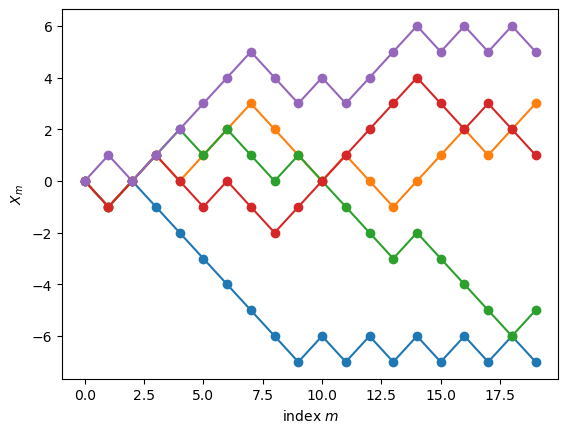

In [6]:
class randomwalk(SP):
    def start(self,random_state):
        return 0.

    def update(self, random_state, history):
        step = np.sign(random_state.uniform()-0.5)
        return history[-1]+step

test=randomwalk(seed=1)
test.create_multiple_processes(20,5)
test.plot_processes()

test.create_multiple_processes(101,5000)

for step in [9,16,25,36,49,64,81,100]:
    mean = test.sequence[step,:].mean()
    std = test.sequence[step,:].std()
    print(f'After {step:>3} steps: mean = {mean:5.3f}, std = {std:6.2f}')

These walks can be made more general by allowing the steps $X_n$ to have some continuous distribution on the reals, and it can be placed in a multi-dimensional space with both positions and steps in $\mathbb{R}^p$. A particularly well-known random walk process involves the motion of a particle in a fluid where it is subjected to multiple collisions. This gives a so called *Brownian motion*.


## Special case: Gaussian process

{{ sub_extra_tif385_admonition }}

The joint density function for a multivariate normal distribution was presented in Eq. {eq}`eq:Statistics:multivariate-normal-PDF` for $\boldsymbol{x} = (x_1, x_2, \ldots, x_k)$ corresponding to random variables $X_1, X_2, \ldots X_k$. This normal distribution is completely determined by its mean vector, $\boldsymbol{\mu}$, and covariance matrix, $\boldsymbol{\Sigma}$, where elements $\mu_i = \expect{X_i}$ and $\Sigma_{ij} = \cov{X_i}{X_j}$.

The multivariate normal distribution has the remarkable property that all marginal and conditional distributions are normal, and specified by the corresponding subsets of the mean vector and covariance matrix. 

A Gaussian process extends the multivariate normal distribution to a stochastic process with a continuous time index $T$.

```{prf:definition} Gaussian process
:label: definition:gaussian-process

A Gaussian process $(X(t))_{t \geq 0}$ is a stochastic process with a continuous-time index $t \in [0,\infty)$ if each finite-dimensional vector of random variables 

$$
X(t_1), X(t_2), \ldots, X(t_k)
$$ 

has a multivariate distribution for $0 \leq t_1 < \ldots < t_k$.

A Gaussian process is completely determined by its *mean function* $\mu(X(t))$ and *covariance function* $C(X(s), X(t))$ for $s, t \geq 0$.

```  

A Gaussian process is stationary if the mean function $\mu(X(t))$ is constant for all $t$ and if the covariance function fulfils $C(X(s), X(t)) = C(X(s+h), X(t+h))$ with $h \geq 0$. Note that stationarity is not a requirement for a Gaussian process.

## Solutions

Here are answers and solutions to selected exercises.

```{solution} exercise:StochasticProcess:first-example
:label: solution:StochasticProcess:first-example
:class: dropdown

- The initial variable is from a uniform distribution: $p_{X_0}(x_0) = \mathcal{U}\left( [0,1] \right)$.
- Variable $X_n$ is obtained from
$p_{X_n \vert X_0, X_1, \ldots, X_{n-1}} \left( x_n | x_0, x_1, \ldots, x_{n-1} \right) = \mathcal{U}\left( [0,1] \right) + \sum_{i=0}^{n-1} x_i$
```

````{solution} exercise:conditional-probabilities-stochastic-process
:label: solution:conditional-probabilities-stochastic-process
:class: dropdown

The histograms on the diagonal show the distributions $\p{X_n}$ which are marginalized over $X_{n−1}, \ldots, X_0$. The off-diagonal plots show the joint distributions $\p{X_i,X_j}$ which are marginalized over $X_{n−1}, \ldots, X_0$ with $n=\max(i,j)$ and excluding $X_{\min(i,j)}$. Note that these are distributions of random variables $X_n$, not random values $x_n$.

More explicitly:

* $\p{X_0}$ has no correlated random variables marginalized out since it starts the sequence.
* $\p{X_1}$ is marginalized over $X_0$.
* $\p{X_2}$ is marginalized over $X_1,X_0$.
* $\p{X_3}$ is marginalized over $X_2,X_1,X_0$.
* $\p{X_0,X_1}$ has no correlated random variables marginalized out.
* $\p{X_1,X_2}$ is marginalized over $X_0$.
* $\p{X_2,X_3}$ is marginalized over $X_0, X_1$.
* $\p{X_1,X_3}$ is marginalized over $X_0, X_2$.
* $\p{X_0,X_3}$ is marginalized over $X_1, X_2$.
* $\p{X_0,X_2}$ is marginalized over $X_1, X_3$.

The dependence of $X_3$ on $X_0$ is not directly observed since $\pdf{X_3}{X_0}$ is not shown. However, from Eq. {eq}`eq:Statistics:conditional-probability` we have that $\pdf{X_3}{X_0} = \p{X_0,X_3} / \p{X_0}$. And since $\p{X_0}$ is uniform, we find that $\pdf{X_3}{X_0} \neq \p{X_3}$.
In other words, $X_3$ "remembers" $X_0$.
````

````{solution} exercise:construct-stochastic-process
:label: solution:construct-stochastic-process
:class: dropdown

Here's one possible solution. It is a slightly more general random walk.

```{code-block} python
class exerciseSP(SP):
    def start(self,random_state):
        return random_state.uniform()

    def update(self, random_state, history):
    	return history[-1] + random_state.uniform())
```
````














%========================
% Extra exercises not yet coordinated with the text.
%========================
%--```{exercise}
%--:label: exercise:the-poisson-process-1
%--
%--This exercise will explore the important Poisson distribution in
%--more detail and illustrate how the Poisson distribution can arise from a 
%--stochastic proccess.
%--
%--Define a stochastic process $\{X_i : i \in \{1,2,\dots\}\}$ where $X_i \sim 
%--\mathrm{exp}(\lambda)$ and independent. This means that the pdf is 
%--
%--$$f_{X_i}(x) = \begin{cases} \lambda e^{-\lambda x},
%--\quad x \geq 0, \\ 0, \quad x < 0. \end{cases}
%--$$
%--
%--This stochatic process is quite trivial, sice it is just an i.i.d sequence of random variables being exponentially 
%--distributed.
%--
%--From this process define a new process $\{T_n : n \in \{1,2,\dots\}\}$ where
%--$T_n = \sum_{i=1}^n X_i$.
%--
%--(i) Show that $\{T_n : n\in\{1,2,\dots\}\}$ is a Markov Process.
%--
%--(ii) Calculate the distribution function (cdf) of $T_n$, i.e. 
%--$F_{T_n} (t) = P(T_n \leq t)$ to show that $T_n \sim \Gamma(\lambda,n)$ 
%--
%--*Hint*: This is most easily shown by indction. (1.) Show that a exponential 
%--distribution is a special case of the $\Gamma$ distribution (2.) Consider 
%--the distribution of $Z = T_{n-1} + X_n$ where you assume that $T_{n-1}$ has a 
%--$\Gamma$--distribution.
%--
%--(iii) (optional) Try implementing this stochastic process in the Python class.
%--
%--
%--(iv) Define a random variable $N(t) =$ max$\{n : T_n \leq t \}$.
%--Show that $N(t) \sim \mathrm{Poisson}(\lambda t)$.
%--
%--*Hint*: First show that $N(t)\geq j$ if and only if  $T_j \leq t$. Use this to express 
%--$P(N(t) = j)$ in terms of the distribution function you calculated earlier.
%--
%--
%--```
%--```{exercise}
%--:label: exercise:the-poisson-process-2
%--This exercise will illustrate another situation where the Poisson distribution 
%--shows up.
%--
%--Consiser a physics experiment where you want to measure some process that emitts 
%--some kind of particle in different directions. The goal is to infer the probability
%--distribution that the particles follow. Consider that the detector is a screen
%--with some length, $L$, which is divided up in $K$ bins. The number of particels 
%--detected in each bin will approach the underlying probability distribution after 
%--long enough time, but for a finite number of samples it may look somethig like the
%--figure below. The red curv is the underlying pdf that we want to know, and the blue
%--histogram shown the outcome of the experiment.
%--
%--![file](./figs/prob_fig.png)
%--
%--We will study the distribution of the number of particles in each bin, and how
%--that is affected by the number of particales that are detected, $N$, and the setup 
%--of the experiment. This distribution is important to be able to cunstruct the 
%--likelihood of the observed data given some model to describe the process.
%--
%--Suppuse that $N_i, \ i=1,\dots,K$ is the number of particles detected in the 
%--experiment in the corresponding bins. Let's focus on bin $i=1$.
%--
%--(*i*) Show that if all the particles can be considered independent the probability
%--of observing $N_i$ particles in bin $i=1$ is following a Binomial distribution. 
%--Assume that the variation of the underlying pdf can be considered constant 
%--in each bin, meaning that the widths of the bins are very small.
%--
%--*Hint*: Use that the random variable $N_i$ is a sum of Bernoulli distributed 
%--random variables.
%--
%--(*ii*) Compute the *generating function* for the Binomial distribution and 
%--the Poisson distribution.
%--
%--*Hint*: Remember that the generating function for a discrete random varaiable, $X$,
%--is defined as
%--
%--$$
%--G(s) =  \mathbb{E}\left(s^{X}\right) = \sum_n s^n \cdot f_X(n).
%--$$
%--
%--For the calculation of the generating function for the binomial distribution
%--you can use the fact that the binomial distribution is a sum of independent 
%--random variables with a generating function that is easier to compute.
%--
%--(*iii*) Prove the so-called Poisson Limit Theorem, that the binomial
%--distribution approaches the Poisson distribution in the limit 
%--
%--$$
%--N \to \infty, \quad N p_i \to \lambda. 
%--$$
%--
%--where $\lambda$ is a finite constant, i.e. 
%--
%--$$
%--P(N_i = n_i) \to_{N\to\infty} \frac{\lambda^{n_i}}{n_i!}e^{-\lambda}
%--$$
%--
%--*Hint*: Use the definition of $e$ and explicitly construct a sequence of decreasing 
%--probabilities $p_i \to_{N\to\infty} 0$ that fulfills the constraint above.
%--
%--(*iv*) Use scipy-stats to compare the binomial distribution and the Poisson distribution
%--and verify that the statement you just prove makes sense. Vary the size of 
%--$\lambda = p_i N \in \{0.5,2,10\}$ for large $N \sim 1000$. What do you observe? 
%--How can you explain it?
%--
%--```
%========================
% Solutions to extra exercises.
%========================
%--```{solution} exercise:the-poisson-process-1
%--:label: solution:the-poisson-process-1
%--:class: dropdown
%--
%--(*i*)
%--- Want to show that
%--
%--$$
%--P(T_n = t_n | T_{n-1} = t_{n-1}, 
%--\dots, T_1 = t_1) = P(T_n=t_n| T_{n-1} = t_{n-1}).
%--$$
%--
%--\begin{align}
%--P(T_n = t_n | T_{n-1} = t_{n-1}, 
%--\dots, T_1 = t_1) =\\= P(X_n + T_{n-1} = t_n | T_{n-1} = t_{n-1}, 
%--\dots, T_1 = t_1) =\\= P(X_n = t_n - t_{n-1}| T_{n-1} = t_{n-1}, 
%--\dots, T_1 = t_1)
%--\end{align}
%--
%--- Multiply and divide by $P(X_{n} | T_n)$ and show by independence that
%--all the remaining factors cancel and you are left with
%--
%--\begin{align}
%--P(T_n = t_n | T_{n-1} = t_{n-1}, 
%--\dots, T_1 = t_1) =\\ = P(X_n=t_n - t_{n-1} | T_{n-1} = t_{n-1}) = 
%--P(T_n=t_n| T_{n-1} = t_{n-1})
%--\end{align}
%--
%--which shows that it is a Markov process.
%--
%--(*ii*)
%--
%--- Use the hint.
%--
%--(*iii*)
%--
%--- We follow the hints.
%--- Assume that $N(t) \geq j$. Since $N(t)$ is the maximum $n$ for whith $T_n \leq t$
%--we get that $T_j \leq t$. Assume that $T_j \leq t$. This means that the maximum 
%--$n$ for which $T_n \leq t$ hold must be larger of equal to $j$, hence $N(t) \leq j$.
%--- The probability $P(N(t) = j)$ can be expressed as
%--
%--$$
%--P(N(t) = j) = P(N(t)\geq j) - P(N(t)\geq j+1).
%--$$
%--
%--By the above equality we can express these probabilities as
%--
%--$$
%--P(N(t) = j) = P(T_j \leq t) - P(T_{j+1} \leq t) = F_{T_j}(t) - F_{T_{j+1}}(t) = 
%--\frac{(\lambda t )^j}{j!} e^{-\lambda t}.
%--$$
%--
%--```
%--
%--
%--```{solution} exercise:the-poisson-process-2
%--:label: solution:the-poisson-process-2
%--:class: dropdown
%--
%--(*i*)
%--- We use the hint and assume that the probability of hitting bin $i$ is $p_i$.
%--This means that each particle is hitting this bin with probability $p_i$ and
%--missing with probability $1-p_i$. This experiment is repeated $N$ times. This means 
%--that
%--
%--$$
%--N_i = \sum_{k=1}^N B_k,  
%--$$
%--where $B_k \sim$ Bernoulli$(p_i)$ and independent. This means that the probability
%--of $n_i$ hits among $N$ can be obtained from the Binomial theorem 
%--
%--$$
%--P(N_i = n_i) = \left(\frac{N}{n_i}\right) p_i^{n_i}(1-p_i)^{N-n_i}.
%--$$
%--
%--(*ii*)
%--
%--- Use the definition of the generating function to obtain for the Poisson
%--distribution
%--
%--$$
%--G_P(s) = \sum_k s^k \frac{\lambda^k}{k!} e^{-\lambda} = e^{\lambda(s-1)}
%--$$
%--
%--- For the Binomial distribution we use the property of the generating functions
%--that $G_{Bin}(s) = \left(G_{Bern}(s)\right)^N$, which holds by independence.
%--
%--$$
%--G_{Bin}(s) = \left( (ps) + (1-p)\right)^N
%--$$
%--
%--(*iii*)
%--- We will prove this by proving that the generating function for the binomial 
%--distribution approaches the generating function for the Poisson distribution in
%--the $N\to \infty$ limit. We drope the $i$ index from now on.
%--
%--- Using the hint an explicit secuence is for example $p_N = \frac{\lambda}{N} + 
%--o\left(\frac{1}{N}\right)$ (The small $o$ notation means that $N^m o(1/N^m)
%--\to_{N\to\infty} 0$) 
%--
%--- Looking at the generating function for the Binomial distribution we have
%--
%--$$
%--(ps + (1-p))^N = (1+p_N(s-1))^N = \exp{\left[N \ln\left( 1 +\frac{\lambda}{N} + 
%--o\left(\frac{1}{N}\right)\right)\left(s-1\right)\right]}
%--$$
%--
%--Taylor expanding the logarithm and takning the limit gives
%--
%--$$
%--\exp\left[N\left(p_N(s-1) + o\left(\frac{1}{N}\right)\right)\right] 
%--\to_{N\to\infty} \exp\left[\lambda(s-1)\right]
%--$$
%--
%--```